# 30-feature-engineering
> Generating new features for the dataset

In this notebook, we generate new features to be used in the dataset.  Keep in mind that depending on the framework you're using, you may want to generate/validate code/functions here to be used as a part of a pipeline in the 40-modeling notebook.

#### Common helpful packages

In [1]:
#Data analysis and processing
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Assertions and testing
import great_expectations as ge

from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import math
from sklearn.decomposition import PCA
from matplotlib import style
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from numpy.linalg import eig
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import scipy.stats as stats
from scipy.stats import kendalltau
import pymannkendall as mk

In [2]:
import glob
import os
path = '/Users/yutingmei/Projects/APlusBernstein-Project/data/raw/FactorTimingData-ABVU2022.xlsx'
path2 = '/Users/yutingmei/Projects/APlusBernstein-Project/data/processed/imputed_na_value_data.xlsx'
raw = pd.read_excel(path, sheet_name = 'price')
target = pd.read_excel(path, sheet_name = 'target')
# dt is the processed data
dt = pd.read_excel(path2)

In [74]:
path3 = '/Users/yutingmei/Projects/APlusBernstein-Project/data/processed/df_imputed.csv'
df_avg = pd.read_csv(path3)

In [15]:
path4 = '/Users/yutingmei/Projects/APlusBernstein-Project/data/processed/dt_imputed_weight.csv'
df_weight = pd.read_csv(path4)

In [3]:
def strip_cols(df):
    update_col = {}
    col_all_list = df.columns.to_list()
    strip_col = list(map(lambda x: x.strip(),col_all_list))
    for q in range(len(col_all_list)):
        update_col[col_all_list[q]]= strip_col[q]   
    df.rename(columns = update_col, inplace=True)
    return df

In [4]:
raw = strip_cols(raw)
raw = raw.iloc[:, 1:]

In [5]:
sc = StandardScaler()
#dt_r_d = pd.DataFrame(sc.fit_transform(dt), columns = dt.columns)
raw = pd.DataFrame(sc.fit_transform(raw), columns = raw.columns)

In [73]:
def strip_col(df):
    update_col = {}
    # for q in range(len(col_list)):
    #     update_col[col_list[q]]= strip_col[q]

    col_all_list = df.columns.to_list()
    strip_col = list(map(lambda x: x.strip(),col_all_list))
    for q in range(len(col_all_list)):
        update_col[col_all_list[q]]= strip_col[q]
        df.rename(columns = update_col, inplace=True)
    return df

In [75]:
df_avg = strip_col(df_avg)

#### filling NA with weight strategy

In [6]:
# handle missing values in front
cols_r = raw.columns.to_list()
missing_index_sum = []
front_miss = []
for i in cols_r:
    missing_index = raw[raw[i].isnull()].index.tolist()
    missing_index_sum.append(missing_index)
    if 0 in missing_index:
        front_miss.append(i)
        
na_l = list(raw.isnull().sum() * 100 / len(raw))
na_col_list = [raw.columns.to_list()[i] for i in range(len(na_l)) if na_l[i] != 0]

In [7]:
def get_percentage(df):
    cols_df = df.columns.to_list()
    percentage_change_sum = pd.DataFrame()
    for i in cols_df:
        percentage_change = []
        for j in range(raw.shape[0] - 1):
            if j == 0:
                percentage_change.append(None)
            else:
                if not pd.isnull(df.loc[j + 1, i]) and not pd.isnull(df.loc[j, i]):
                    percentage_change.append((df.loc[j + 1, i] - df.loc[j , i]) / df.loc[j , i])
                else:
                    percentage_change.append(None)
        percentage_change_sum[i] = percentage_change
    return percentage_change_sum

In [11]:
def impute_forward(df, miss_cols):
    corr_matrix = df.corr().abs()
    #weight_sum_l = corr_matrix.sum() - 1
    raw_percentage = get_percentage(df)
    # for i in range(df.shape[1]):
    #     corr_matrix.iloc[:, i] = corr_matrix.iloc[:, i] / weight_sum_l[i]
    for k in miss_cols:
        missing_l = df[df[k].isnull()].index.tolist()
        for j in missing_l[::-1]:
            if j < (df.shape[0] - 1) and j != 0:
                col_index = df.columns.get_loc(k)
                raw_percentage_minus = raw_percentage.loc[:, raw_percentage.columns != k]
                corr_matrix_col = corr_matrix.loc[:, k]
                corr_matrix_minus = [corr_matrix_col[i] for i in range(len(corr_matrix_col)) if i != col_index]
                weighted = 0
                sum_corr = 0
                for i in range(len(corr_matrix_minus)):
                    if not pd.isnull(raw_percentage_minus.iloc[j, i]):
                        sum_corr += corr_matrix_minus[i]
                for i in range(len(corr_matrix_minus)):
                    if not pd.isnull(corr_matrix_minus[i]) and not pd.isnull(raw_percentage_minus.iloc[j, i]):
                        weighted += (corr_matrix_minus[i] / sum_corr) * raw_percentage_minus.iloc[j, i]
                    df[k][j] = df[k][j + 1] / (weighted + 1)
            elif j == 0:
                df[k][j] = df[k][j + 1] + np.random.normal()
            elif j == df.shape[0] - 1:
                df[k][j] = df[k][j - 1] + np.random.normal()
    return df

In [12]:
raw_processed = impute_forward(raw, na_col_list)

In [15]:
na_after = list(raw_processed.isnull().sum() * 100 / len(raw_processed))
na_after_list = [raw_processed.columns.to_list()[i] for i in range(len(na_after)) if na_after[i] != 0]

In [18]:
# still have some columns with NAs
# since it impute forward, some columns with NAs at the end still can't impute
na_after_list

['Oil Vol',
 'Ted Spread',
 'Global Economic Policy Uncertainty',
 'JPM Equity Sentiment']

In [50]:
# from lag plots, it showed there's no seasonality within data
# but some might has trend
# do Kendall’s Tau test about whether there's trend within columns with NAs
# linear interpolation: data with trend
# median imputation: data without trend

for i in na_after_list:
    check_trend = list(mk.original_test(raw_processed[i]))
    if check_trend[1] == True:
        raw_processed[i] = raw_processed[i].interpolate()
    else:
        raw_processed[i].fillna(raw_processed[i].median(), inplace = True)

In [54]:
na_check = list(raw_processed.isnull().sum() * 100 / len(raw_processed))
# check if still have NAs, if no, should be True
len([i for i in na_check if i == 0]) == raw_processed.shape[1]

True

In [56]:
path_g = '/Users/yutingmei/Projects/APlusBernstein-Project/data/processed/'
raw_processed.to_csv(path_g + 'dt_imputed_weight.csv', index = False)

## feature selection

* deal with missing values

In [62]:
na_l = list(raw.isnull().sum() * 100 / len(raw))

In [63]:
filter_na = [i for i in range(len(raw.columns)) if na_l[i] == 0]
less_50 = [i for i in range(len(raw.columns)) if na_l[i] <= 50 and na_l[i] != 0]
equal90 = [i for i in range(len(raw.columns)) if na_l[i] >= 90]

In [21]:
# remove them first
equal90

[80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92]

In [22]:
with_na = list(set([i for i in range(len(raw.columns))]) - set(filter_na))

In [16]:
sum = {}
for i in with_na:
    sum[[j.strip() for j in dt.columns.tolist()][i]] = na_l[i]
    
sum_50 = {}
for i in less_50:
    sum_50[[j.strip() for j in dt.columns.tolist()][i]] = na_l[i]
    

In [4]:
# drop the features with high missing values proportions
#need_to_drop = [dt.columns.to_list()[i] for i in equal90]
#dt_r = dt.drop(need_to_drop, axis = 1)
#dt_r_d = dt_r.iloc[:,1:]
sc = StandardScaler()
dt_r_d = pd.DataFrame(sc.fit_transform(dt), columns = dt.columns)

##### issue with multicollinearity( with data filled with NA by simple method)

* correlation coefficient 

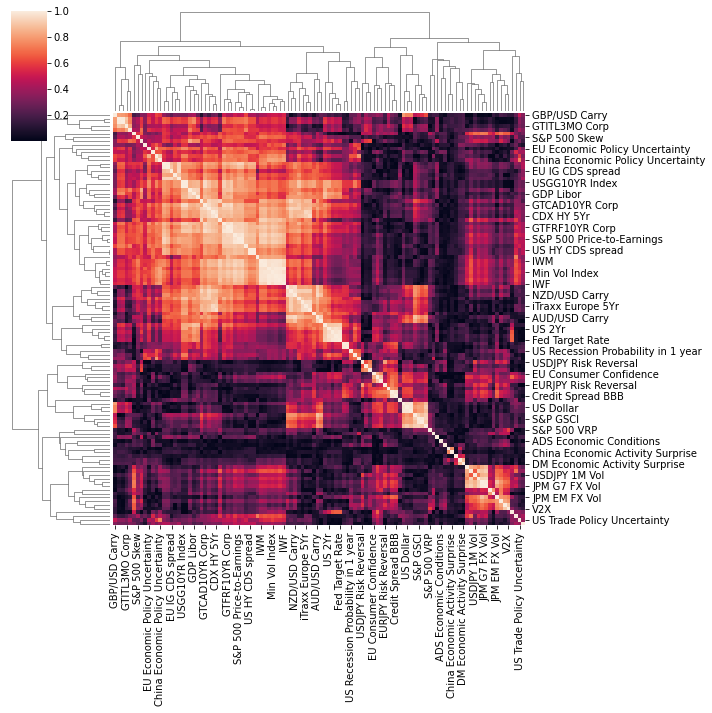

In [25]:
# rough look
# > 0.7 can be seen as threshold
sns.clustermap(dt_r_d[list(map(lambda x: x.strip(), dt_r_d.columns.tolist()))].corr().abs())

In [26]:
# add y
#dt_r_d[target.columns.to_list()[-3:]] = target.iloc[:,-3:]

### Deal with multicolinearity

#### tolerrant method: lasso

_result compare_: the first edition, weight edition, average edition

In [58]:
lasso = Lasso()
alpha_range = np.linspace(0.001,0.01, num=100)
params = {'alpha':alpha_range}
# scoring = ?
lassoreg = GridSearchCV(lasso, params, cv = 10)

In [48]:
def get_lasso(df, target):
    coef_sum = []
    if df.shape[0] == 5306:
        df = df.iloc[1:-1,:]
    for i in range(3, 0, -1):
        lassoreg.fit(df, target.iloc[:,-i])
        clf = Lasso(alpha=lassoreg.best_params_['alpha'])
        clf.fit(df, target.iloc[:,-i])
        print(lassoreg.best_params_)
        index = [i for i in range(len(list(clf.coef_))) if list(clf.coef_)[i] != 0]
        coef_sum.append(index)
    return coef_sum

- the first edition

In [7]:
# the index of features for three models
# result with the first edition of NA imputation
coef_sum

[[21, 26, 59, 75, 79, 89, 94],
 [1, 13, 14, 15, 23, 36, 40, 79, 84, 85, 91],
 [0, 1, 11, 15, 28, 40, 46, 64, 76, 77, 81, 85, 91, 99, 101, 109]]

In [8]:
# print name of columns
# result with the first edition of NA imputation
[[pd.Series(dt_r_d.columns.to_list())[i]] for i in coef_sum]

[[21                           WTI Crude Oil
  26                    iTraxx Crossover 5Yr
  59                       EquityBond premia
  75           EM Economic Activity Surprise
  79        Citi US Inflation Surprise Index
  89    Conference Board Consumer Confidence
  94                                     IWM
  dtype: object],
 [1                                   V2X
  13                          S&P 500 VRP
  14                         S&P 500 Skew
  15                 EURUSD Risk Reversal
  23                                 Gold
  36                       US 10Y over 3M
  40                        GTGBP3MO Corp
  79     Citi US Inflation Surprise Index
  84       EU Economic Policy Uncertainty
  85    China Economic Policy Uncertainty
  91               EU Consumer Confidence
  dtype: object],
 [0                                    VIX
  1                                    V2X
  11                         USDJPY 1M Vol
  15                  EURUSD Risk Reversal
  28           

- weight edition

In [93]:
lasso = Lasso()
alpha_range = np.linspace(0.01,0.25, num=150)
params = {'alpha':alpha_range}
# scoring = ?
lassoreg = GridSearchCV(lasso, params, cv = 10)

In [94]:
# the index of features for three models
# result with the weight edition of NA imputation
coef_sum_2 = get_lasso(raw_processed)
coef_sum_2

{'alpha': 0.018053691275167785}
{'alpha': 0.25}
{'alpha': 0.16624161073825502}


[[2,
  4,
  8,
  16,
  17,
  25,
  26,
  27,
  28,
  31,
  40,
  44,
  46,
  53,
  55,
  56,
  57,
  58,
  65,
  66,
  67,
  68,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  95,
  109],
 [2,
  4,
  17,
  26,
  27,
  28,
  31,
  40,
  44,
  55,
  56,
  57,
  58,
  65,
  66,
  67,
  68,
  77,
  78,
  82,
  83,
  84,
  85,
  86,
  90,
  95,
  109],
 [2,
  4,
  26,
  27,
  28,
  31,
  40,
  44,
  55,
  56,
  57,
  58,
  65,
  66,
  67,
  68,
  77,
  78,
  80,
  82,
  83,
  84,
  86,
  90,
  91,
  95,
  109]]

In [95]:
# print name of columns
# result with the weight edition of NA imputation
[[pd.Series(raw_processed.columns.to_list())[i]] for i in coef_sum_2]

[[2                                    MSCI EM Vol
  4                                        Oil Vol
  8                                  JPM G7 FX Vol
  16                          USDJPY Risk Reversal
  17                          EURJPY Risk Reversal
  25                             iTraxx Europe 5Yr
  26                          iTraxx Crossover 5Yr
  27                                    CDX IG 5Yr
  28                                    CDX HY 5Yr
  31                                           JPY
  40                                 GTGBP3MO Corp
  44                                 GTDEM3MO Corp
  46                                 GTITL3MO Corp
  53                                     GDP Libor
  55                     S&P 500 Price-to-Earnings
  56                                           P/B
  57                  US Value P/E over Growth P/E
  58                  US Value P/B over Growth P/B
  65                              US IG CDS spread
  66                           

#### variance inflation factor

_result compare_: the first edition, weight edition, average edition

- the first edition

In [72]:
# a measure of the amount of multicollinearity in a set of multiple regression variables
# only be implemented after filling NA
# more than 5 ~ 15( don't know exact threshold ) can be seen as high, then can be removed
# can also be seen as method for testing if still have multicolinearity

def vif(coef, df):
    f_info = pd.DataFrame()
    f_info['variance_inflation_factor'] = [variance_inflation_factor(df.iloc[:, coef].values, i) for i in range(df.iloc[:, coef].shape[1])]
    f_info['Column'] = df.iloc[:, coef].columns
    f_info.sort_values('variance_inflation_factor', ascending=False)
    return f_info

In [12]:
# test multicollinearity from lasso
# some still have high vif, need to be removed
# result with the first edition of NA imputation
for i in range(3):
    print(f"{i + 1}"'. vif:')
    print(vif(coef_sum[i]))
    print('*'* 70)

1. vif:
   variance_inflation_factor                                Column
0                   1.671168                         WTI Crude Oil
1                   7.761000                  iTraxx Crossover 5Yr
2                   3.073055                     EquityBond premia
3                   1.052805         EM Economic Activity Surprise
4                   1.288013      Citi US Inflation Surprise Index
5                   2.573111  Conference Board Consumer Confidence
6                   6.821109                                   IWM
**********************************************************************
2. vif:
    variance_inflation_factor                             Column
0                    2.108380                                V2X
1                    2.143130                        S&P 500 VRP
2                    1.966768                       S&P 500 Skew
3                    1.819018               EURUSD Risk Reversal
4                    4.126071                       

In [67]:
rv_list = [[1], [], [0, 4, 13, 14]]
#rv_valuel = list(map(lambda x,y: list(np.array(x)[y]), coef_sum, rv_list))
coef_sum_rv = list(map(lambda x,y: list(np.array(x)[list(set(range(len(x))) - set(y))]), coef_sum, rv_list))

In [68]:
# test again
for i in range(3):
    print(f"{i + 1}"'. vif:')
    print(vif(coef_sum_rv[i]))
    print('*'* 70)

1. vif:
   variance_inflation_factor                                Column
0                   1.558173                         WTI Crude Oil
1                   2.572637                     EquityBond premia
2                   1.046345         EM Economic Activity Surprise
3                   1.242535      Citi US Inflation Surprise Index
4                   2.532893  Conference Board Consumer Confidence
5                   2.178781                                   IWM
**********************************************************************
2. vif:
    variance_inflation_factor                             Column
0                    2.108380                                V2X
1                    2.143130                        S&P 500 VRP
2                    1.966768                       S&P 500 Skew
3                    1.819018               EURUSD Risk Reversal
4                    4.126071                               Gold
5                    1.915998                     US 1

In [74]:
path_g = '/Users/yutingmei/Projects/APlusBernstein-Project/data/processed/'
for i in range(3):
    dt_r_d.iloc[:, coef_sum_rv[i]].to_csv(path_g + 'dt_processed_corr_' + str(i), index = False)

* the weight edition

In [96]:
# terrible
for i in range(3):
    print(f"{i + 1}"'. vif:')
    print(vif(coef_sum_2[i], raw_processed))
    print('*'* 70)

1. vif:
    variance_inflation_factor                                     Column
0                    1.139993                                MSCI EM Vol
1                    1.274653                                    Oil Vol
2                    1.192796                              JPM G7 FX Vol
3                   60.576722                       USDJPY Risk Reversal
4                   35.381435                       EURJPY Risk Reversal
5                 6573.620702                          iTraxx Europe 5Yr
6                 5177.812970                       iTraxx Crossover 5Yr
7                11443.427669                                 CDX IG 5Yr
8                20293.818594                                 CDX HY 5Yr
9                    4.208751                                        JPY
10                   1.457663                              GTGBP3MO Corp
11                   7.777589                              GTDEM3MO Corp
12                  11.340515              

In [97]:
rv_list_2 = [list(range(3, 10)) +[11, 12, 31, 33]+ list(range(14, 22))+ list(range(35, 39)), 
             list(range(2, 6)) + list(range(9, 17)) + [23, 25, 26], 
             list(range(2, 5)) + list(range(8, 16)) + list(range(23, 27))]
coef_sum_rv_2 = list(map(lambda x,y: list(np.array(x)[list(set(range(len(x))) - set(y))]), coef_sum_2, rv_list_2))

In [98]:
# test
# still need to remove some
for i in range(3):
    print(f"{i + 1}"'. vif:')
    print(vif(coef_sum_rv_2[i], raw_processed))
    print('*'* 70)

1. vif:
    variance_inflation_factor                                Column
0                    1.091968                           MSCI EM Vol
1                    1.015478                               Oil Vol
2                    1.142778                         JPM G7 FX Vol
3                    1.579551                    US ISM Service PMI
4                    1.090743  Conference Board Consumer Confidence
5                    1.017547                         GTGBP3MO Corp
6                    1.000800                             GDP Libor
7                    1.006229      China Economic Activity Surprise
8                    1.017572    US Recession Probability in 1 year
9                    1.553123      Citi US Inflation Surprise Index
10                   1.181141    Global Economic Policy Uncertainty
11                   1.162875           US Trade Policy Uncertainty
12                   1.816566        US Monetary Policy Uncertainty
13                   1.010513        US 

In [99]:
path_g = '/Users/yutingmei/Projects/APlusBernstein-Project/data/processed/'
for i in range(3):
    raw_processed.iloc[:, coef_sum_rv_2[i]].to_csv(path_g + 'dt_processed_weight_' + str(i), index = False)

## Dimension reduction

In [53]:
# sc = StandardScaler()
# X_scaled = sc.fit_transform(dt.iloc[:,filter_na[1:]])
pca = PCA(n_components = dt_r_d.shape[1])
pca.fit_transform(dt_r_d)

array([[ 1.28036132e+01, -2.28975111e+00,  4.95830367e+00, ...,
         3.78432451e-02,  2.94088506e-03, -1.25489652e-16],
       [ 1.07163611e+01, -6.90037227e+00,  2.49532210e+00, ...,
         3.28654654e-03,  7.27224107e-03, -7.08420173e-16],
       [ 1.05488322e+01, -7.05532075e+00,  2.36751171e+00, ...,
        -7.17998562e-04,  6.29226733e-03, -1.05017797e-15],
       ...,
       [-1.13749374e+01, -4.31308245e+00, -1.47988379e+00, ...,
         2.85029440e-02, -2.52698686e-04, -3.44183486e-16],
       [-1.13277900e+01, -4.24403911e+00, -1.45224924e+00, ...,
         3.07420562e-02, -5.09449431e-04,  6.58870914e-17],
       [-1.10831454e+01, -4.28472692e+00, -1.37174467e+00, ...,
         3.21284040e-02,  1.61932177e-03,  5.69189125e-16]])

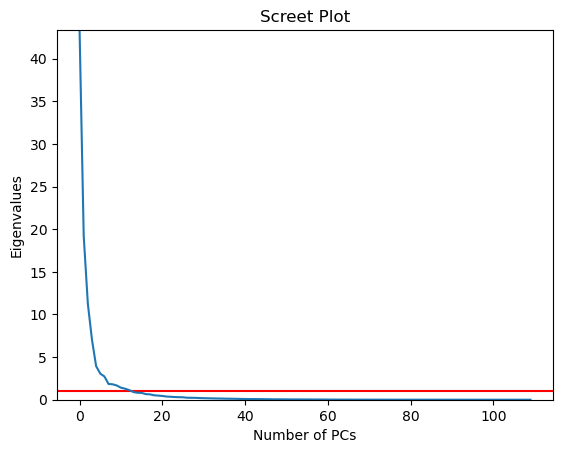

Text(0.5, 1.0, 'Explained Variance of PCA by Component')

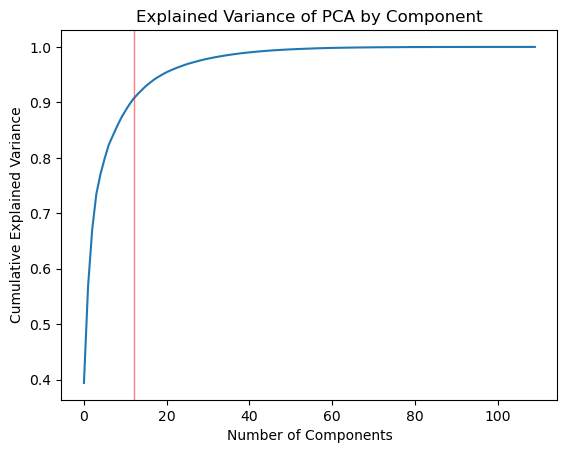

In [56]:
plt.style.use('default')
plt.ylabel('Eigenvalues')
plt.xlabel('Number of PCs')
plt.ylim(0, max(pca.explained_variance_))
plt.axhline(y = 1, color = 'r')
plt.plot(pca.explained_variance_)
plt.title('Screet Plot')
plt.show()

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=12, linewidth=1, color='r', alpha=0.5)
plt.title('Explained Variance of PCA by Component')

In [59]:
def fa(n_factors_end):
    for i in range(2, n_factors_end):
        fa = FactorAnalyzer(n_factors=i, rotation="varimax", method="principal", 
                    is_corr_matrix=False)
        fa.fit(dt_r_d)
        print("Eigenvalues:")
        print(fa.get_eigenvalues()[0])
        print()
        print("Communalities:")
        print(fa.get_communalities())
        print()
        print("Specific Variances:")
        print(fa.get_uniquenesses())
        print()
        print("Factor Loadings:")
        print(fa.loadings_)
    plt.plot(fa.get_eigenvalues()[0], marker='o')
    plt.xlabel("Eigenvalue number")
    plt.ylabel("Eigenvalue size")
    plt.title("Scree Plot")

Eigenvalues:
[4.33518023e+01 1.92209392e+01 1.12471902e+01 7.03036969e+00
 3.94039508e+00 3.06310742e+00 2.73042577e+00 1.84595880e+00
 1.80924736e+00 1.66799458e+00 1.41031673e+00 1.29336998e+00
 1.13090482e+00 9.03090383e-01 8.16739515e-01 8.03382362e-01
 6.54396105e-01 6.31569787e-01 5.19918430e-01 4.83332822e-01
 4.39333258e-01 3.72665816e-01 3.46136788e-01 3.15043347e-01
 2.96870523e-01 2.88176750e-01 2.33484722e-01 2.27080073e-01
 2.19752524e-01 1.96845160e-01 1.81725137e-01 1.69429029e-01
 1.57378870e-01 1.43877123e-01 1.38651361e-01 1.27308847e-01
 1.17244947e-01 1.14272827e-01 1.02273202e-01 9.22665743e-02
 8.72426920e-02 7.80627394e-02 7.69099886e-02 7.41873636e-02
 6.82922557e-02 6.12746137e-02 5.53634506e-02 4.84415172e-02
 4.79732453e-02 4.53093993e-02 4.02735985e-02 3.78281356e-02
 3.54579085e-02 3.39205611e-02 3.11410363e-02 3.02818405e-02
 2.73994799e-02 2.52537453e-02 2.44146696e-02 2.15459605e-02
 1.81275528e-02 1.62103074e-02 1.50080877e-02 1.44244398e-02
 1.27203358

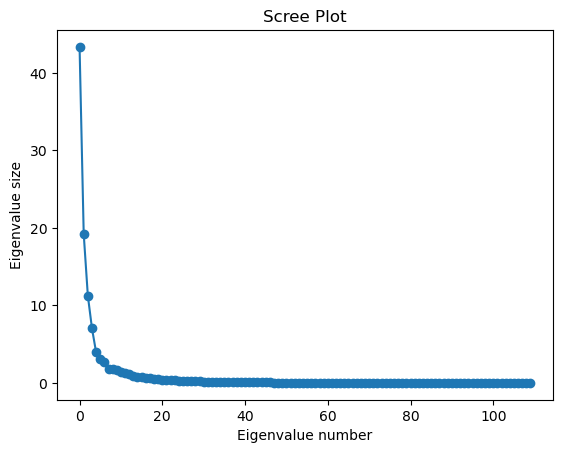

In [60]:
fa(5)

# Feature investigation and creation